In [18]:
import pandas as pd
import codecs
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import optuna
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

with codecs.open("data/AllTokyo_202001_202109.csv", "r", "Shift-JIS", "ignore") as file:
    df = pd.read_table(file, delimiter=",")

In [19]:
df = df.drop(['No', '都道府県名'], axis=1)

In [20]:
# df[df['用途']=='住宅' and (df['種類']=='中古マンション等' or df['種類']=='宅地(土地と建物)')]
df = df[ (df['用途']=='住宅') &  ( (df['種類']=='中古マンション等') | (df['種類']=='宅地(土地と建物)') )]

### preprocessing columns

In [21]:
# df = df.dropna(subset=['建築年', '取引価格（総額）', '延床面積（u）'])
df = df.dropna(subset=['建築年', '取引価格（総額）'])
df = df[df['建築年'] != '戦前']

In [22]:
# 昭和元年 : 1926年, 平成元年: 1989, 令和元年: 2019
df['年号'] = df['建築年'].str[:2]

df['和暦_年'] = df['建築年'].str[2:].str.replace('年','').replace('','0').astype(int)
df.loc[df['年号']=='明治','建築年'] = df['和暦_年'] + 1867
df.loc[df['年号']=='大正','建築年'] = df['和暦_年'] + 1911
df.loc[df['年号']=='昭和','建築年'] = df['和暦_年'] + 1925
df.loc[df['年号']=='平成','建築年'] = df['和暦_年'] + 1988
df.loc[df['年号']=='令和','建築年'] = df['和暦_年'] + 2018

In [23]:
# 昭和元年 : 1926年, 平成元年: 1989, 令和元年: 2019
df['取引時点'] = df['取引時点'].str[:4].astype(int) + df['取引時点'].str[6].astype(int) / 4

In [24]:
df.columns

Index(['種類', '地域', '市区町村コード', '市区町村名', '地区名', '最寄駅：名称', '最寄駅：距離（分）',
       '取引価格（総額）', '坪単価', '間取り', '面積（u）', '取引価格（u単価）', '土地の形状', '間口',
       '延床面積（u）', '建築年', '建物の構造', '用途', '今後の利用目的', '前面道路：方位', '前面道路：種類',
       '前面道路：幅員（ｍ）', '都市計画', '建ぺい率（％）', '容積率（％）', '取引時点', '改装', '取引の事情等', '年号',
       '和暦_年'],
      dtype='object')

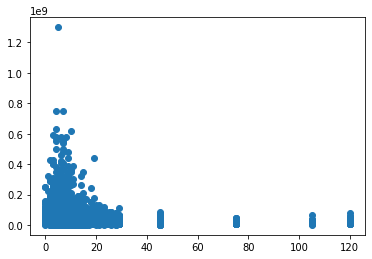

In [25]:
# df.plot.scatter(x = '最寄駅：距離（分）', y = '取引価格（総額）');
df["最寄駅：距離（分）"].replace({"30分?60分":45, "1H?1H30":75, "1H30?2H":105, "2H?":120}, inplace = True)
# df["最寄駅：距離（分）"].replace({"30分?60分":30, "1H?1H30":30, "1H30?2H":30, "2H?":30}, inplace = True)
df['最寄駅：距離（分）'] = df['最寄駅：距離（分）'].astype('float64')
# df.loc[:,"最寄駅：距離（分）"] = df["最寄駅：距離（分）"].fillna(df["最寄駅：距離（分）"].mean())
# print(df["最寄駅：距離（分）"].mean())
df["距離既知フラグ"] =  df["最寄駅：距離（分）"] !=  df["最寄駅：距離（分）"]
df.loc[:,"最寄駅：距離（分）"] = df["最寄駅：距離（分）"].fillna(120)

df["駅近フラグ"] = (df['最寄駅：距離（分）'] < 11) & (df['最寄駅：距離（分）'] > 1)
df = pd.get_dummies(data=df, columns=["駅近フラグ"])
df = pd.get_dummies(data=df, columns=["距離既知フラグ"])

df = df.dropna(subset=["最寄駅：距離（分）"])

plt.scatter(df['最寄駅：距離（分）'].astype(int), df['取引価格（総額）'].astype(int))

In [26]:
num_columns = ['面積（u）']


####################################

# #50.0m以上の間口がある行と，面積が2000m²以上となっている行を削除
df = df[df['間口'] != '50.0m以上']
df = df[df['面積（u）'] != '2000u以上']#エラー表示から，m²がuであらわされていることが判明．
df = df[df['延床面積（u）'] != '2000u以上']


#平均値で欠損値を埋める．
df['間口'] = df['間口'].astype('float64')
df.loc[:,"間口"] = df["間口"].fillna(df["間口"].mean())



#面積（u）と延べ床面積と建築年を実数型にする．
df['面積（u）'] = df['面積（u）'].astype('float64')
df['延床面積（u）'] = df['延床面積（u）'].astype('float64')
df['建築年'] = df['建築年'].astype('float64')


#文字型のデータを一括で30(分)に変換する．
# # df["最寄駅：距離（分）"].replace({"30分?60分":30, "1H?1H30":30, "1H30?2H":30, "2H?":30}, inplace = True)

# #文字型を実数型に変換．
# df['最寄駅：距離（分）'] = df['最寄駅：距離（分）'].astype('float64')

# df.loc[:,"最寄駅：距離（分）"] = df["最寄駅：距離（分）"].fillna(df["最寄駅：距離（分）"].mean())


# df = df.dropna(subset=['市区町村コード', '坪単価','取引価格（u単価）' ])

####################################

df = df.reset_index()

print(df.columns)
for column in df.columns:
    if df.dtypes[column] == 'object' and column not in num_columns:
        target_column = df[column].astype(str)
        le = preprocessing.LabelEncoder()
        le.fit(target_column)
        label_encoded_column = le.transform(target_column)
        df = pd.get_dummies(data=df, columns=[column])
#         df.drop(columns=[column], axis=1, inplace=True)
#         df[column] = pd.Series(label_encoded_column).astype('category')


for column in num_columns: 
    df[column] = df[column].astype('int64')



Index(['index', '種類', '地域', '市区町村コード', '市区町村名', '地区名', '最寄駅：名称', '最寄駅：距離（分）',
       '取引価格（総額）', '坪単価', '間取り', '面積（u）', '取引価格（u単価）', '土地の形状', '間口',
       '延床面積（u）', '建築年', '建物の構造', '用途', '今後の利用目的', '前面道路：方位', '前面道路：種類',
       '前面道路：幅員（ｍ）', '都市計画', '建ぺい率（％）', '容積率（％）', '取引時点', '改装', '取引の事情等', '年号',
       '和暦_年', '駅近フラグ_False', '駅近フラグ_True', '距離既知フラグ_False', '距離既知フラグ_True'],
      dtype='object')


In [27]:
df

,index,市区町村コード,最寄駅：距離（分）,取引価格（総額）,坪単価,面積（u）,取引価格（u単価）,間口,延床面積（u）,建築年,...,取引の事情等_私道を含む取引,取引の事情等_調停・競売等,取引の事情等_調停・競売等、私道を含む取引,取引の事情等_関係者間取引,取引の事情等_関係者間取引、私道を含む取引,取引の事情等_隣地の購入,取引の事情等_隣地の購入、私道を含む取引,年号_令和,年号_平成,年号_昭和
0,0,13101,5.0,59000000,NaN,35,NaN,7.349369,NaN,2007.0,...,0,0,0,0,0,0,0,0,1,0
1,1,13101,5.0,23000000,NaN,20,NaN,7.349369,NaN,2003.0,...,0,0,0,0,0,0,0,0,1,0
2,2,13101,5.0,26000000,NaN,20,NaN,7.349369,NaN,2003.0,...,0,0,0,0,0,0,0,0,1,0
3,4,13101,3.0,58000000,NaN,95,NaN,7.349369,NaN,1985.0,...,0,0,0,0,0,0,0,0,0,1
4,5,13101,3.0,42000000,NaN,70,NaN,7.349369,NaN,1985.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32637,41727,13364,120.0,4000000,NaN,220,NaN,15.000000,95.0,1972.0,...,0,0,0,0,0,0,0,0,0,1
32638,41728,13381,120.0,4500000,NaN,690,NaN,26.000000,80.0,1969.0,...,0,0,0,0,0,0,0,0,0,1
32639,41731,13401,120.0,11000000,NaN,500,NaN,33.500000,90.0,1981.0,...,0,0,0,0,0,0,0,0,0,1
32640,41732,13401,120.0,12000000,NaN,460,NaN,16.700000,100.0,1982.0,...,0,0,0,0,0,0,0,0,0,1


In [28]:
# plt.scatter('取引価格（総額）', '建築年', data=df)
# データセットを説明変数と目的変数に分割
X, y = df.drop('取引価格（総額）', axis=1), df['取引価格（総額）']

In [29]:
# df = df.dropna()
# df

In [30]:
from sklearn.model_selection import train_test_split
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# X_eval, X_test, y_eval, y_test = train_test_split(X_val, y_val, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [31]:
!pip install lightgbm

In [32]:
# ########## parameter search
# from sklearn.metrics import mean_squared_error
# import lightgbm as lgb
# import optuna
# from sklearn.model_selection import KFold

# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_squared_error
# import numpy as np

# def objective(trial):
#     import optuna.integration.lightgbm as lgb
    
    
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
#     X_eval, _, y_eval, _ = train_test_split(X_val, y_val, test_size=0.2, random_state=42)
    
# #     X_train, X_val, y_train, y_val, test = train_test_split(X, y, test_size=0.2, random_state=42)
# #     X_test = test.copy()
    
#     params_dist = {
#         'boosting'          : 'gbdt',
#         'objective': 'regression',      # 目的関数：回帰
#         'metric': 'rmse',               # 分類モデルの性能を測る指標
#         'learning_rate'     : 0.05,
#         'lambda_l1'         : trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
#         'lambda_l2'         : trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
#         'num_leaves'        : trial.suggest_int('num_leaves', 2, 512),
#         'feature_fraction'  : trial.suggest_uniform('feature_fraction', 0.4, 1.0),
#         'bagging_fraction'  : trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
#         'bagging_freq'      : trial.suggest_int('bagging_freq', 0, 10),
#         'min_child_samples' : trial.suggest_int('min_child_samples', 5, 100),
#         'seed'              : 42,
#         'verbosity'         : -1,
#     }
    
#     # 学習データの数だけの数列（0行から最終行まで連番）
#     row_no_list = list(range(len(y_train)))

#     # KFoldクラスをインスタンス化（これを使って5分割する）
#     K_fold = KFold(n_splits=10, shuffle=True,  random_state=42)

#     # KFoldクラスで分割した回数だけ実行（ここでは5回）
#     for train_cv_no, eval_cv_no in K_fold.split(row_no_list, y_train):
#         # ilocで取り出す行を指定
#         X_train_cv = X_train.iloc[train_cv_no, :]
#         y_train_cv = pd.Series(y_train).iloc[train_cv_no]
#         X_eval_cv = X_train.iloc[eval_cv_no, :]
#         y_eval_cv = pd.Series(y_train).iloc[eval_cv_no]    
    
#         lgb_train = lgb.Dataset(X_train_cv, y_train_cv)
#         lgb_eval  = lgb.Dataset(X_eval_cv, y_eval_cv, reference=lgb_train)

#         evaluation_results = {}
#         model = lgb.train(params_dist,
#                           lgb_train,
#                           valid_sets=(lgb_train, lgb_eval),
#                           valid_names=["Train", "Test"],
#                           evals_result=evaluation_results,
#                           num_boost_round=100000,
#                           early_stopping_rounds=100,
#                           verbose_eval=-1,
#                           )
    
#         y_prob_val = model.predict(X_val, num_iteration=model.best_iteration)
#         y_pred_val = np.round(y_prob_val)

#         score = mean_squared_error(np.round(y_val.values), np.round(y_pred_val))
#     return score 

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)

# bestparams = study.best_trial.params
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)

# lgbm(bestparams)

In [33]:
!pip install --upgrade pandas


# 5つのモデルを保存するリストの初期化
models = []

# 学習用データでの予測値を保存するデータフレームの初期化
df_train_preds = pd.DataFrame({'y_train': y_train})

# 検証用データでの予測値を保存するデータフレームの初期化
df_eval_preds = pd.DataFrame({'y_eval': [],
                              'y_eval_pred': []})

# テストデータでの予測値を保存するデータフレームの初期化
df_test_preds = pd.DataFrame({'y_test': y_test})
# インデックスが0からの連番になるように初期化

df_test_preds.reset_index(inplace=True, drop=True)

# R^2を保存するデータフレームの初期化
df_R2 = pd.DataFrame({'train': [],
                      'eval': [],
                      'test': []})

# RMSEを保存するデータフレームの初期化
df_RMSE =pd.DataFrame({'train': [],
                       'eval': [],
                       'test': []})


# ラウンド数の初期化
round_no = 0


# 【ブロック２：　モデルの学習】
# 学習データの数だけの数列（0行から最終行まで連番）
row_no_list = list(range(len(y_train)))

# KFoldクラスをインスタンス化（これを使って5分割する）
K_fold = KFold(n_splits=10, shuffle=True,  random_state=42)

# KFoldクラスで分割した回数だけ実行（ここでは5回）
for train_cv_no, eval_cv_no in K_fold.split(row_no_list, y_train):
    # ilocで取り出す行を指定
    X_train_cv = X_train.iloc[train_cv_no, :]
    y_train_cv = pd.Series(y_train).iloc[train_cv_no]
    X_eval_cv = X_train.iloc[eval_cv_no, :]
    y_eval_cv = pd.Series(y_train).iloc[eval_cv_no]
    
    # 学習用
    lgb_train = lgb.Dataset(X_train_cv, y_train_cv,
                            free_raw_data=False)
    # 検証用
    lgb_eval = lgb.Dataset(X_eval_cv, y_eval_cv, reference=lgb_train,
                           free_raw_data=False)
    
    # パラメータを設定
    params = {
#               'boosting_type': 'gbdt',        # 勾配ブースティング
              'objective': 'regression',      # 目的関数：回帰
              'metric': 'rmse',               # 分類モデルの性能を測る指標
              'learning_rate': 0.03,            # 学習率（初期値0.1）
#               'max_depth': 3,
#               'num_leaves': 10,
#               'feature_fraction':0.7,
#               'bagging_fraction':1,
#               'bagging_freq':20,
#               'n_jobs':5,        
              'lambda_l1': 3, 
#               'max_depth' : 7
    }
    
    # 学習
    evaluation_results = {}                              # 学習の経過を保存する箱
    model = lgb.train(params,                            # 上記で設定したパラメータ
                      lgb_train,                         # 使用するデータセット
                      num_boost_round=100000,              # 学習の回数
                      valid_names=['train', 'valid'],    # 学習経過で表示する名称
                      valid_sets=[lgb_train, lgb_eval],  # モデル検証のデータセット
                      evals_result=evaluation_results,   # 学習の経過を保存
                      early_stopping_rounds=1000,          # アーリーストッピング
                      verbose_eval=0)                    # 学習の経過の非表示
    
    # 学習が終わったモデルをリストに保存
    models.append(model) 
    
    
    # 【ブロック３：　モデルで予測】
    # 学習したモデルで予測
    y_train_pred = model.predict(X_train_cv, num_iteration=model.best_iteration)
    y_eval_pred = model.predict(X_eval_cv, num_iteration=model.best_iteration)
    y_test_pred = model.predict(X_test, num_iteration=model.best_iteration)
    
    # 学習用データでの予測値をデータフレームに保存
    df_train_cv_pred = pd.DataFrame({round_no: y_train_pred},
                                     index=train_cv_no)
    df_train_preds = df_train_preds.join(df_train_cv_pred, how='left')
    
    # 検証用データでの予測値をデータフレームに保存
    df_eval_pred = pd.DataFrame({'y_eval': y_eval_cv,
                                 'y_eval_pred': y_eval_pred})
    df_eval_preds = df_eval_preds.append(df_eval_pred)    
    
    # テストデータでの予測値をデータフレームに保存
    df_test_cv_pred = pd.DataFrame({round_no: y_test_pred})
    df_test_preds = pd.concat([df_test_preds, df_test_cv_pred], axis=1)

    #  r2_score を計算
    train_score = r2_score(y_train_cv, y_train_pred)
    eval_score = r2_score(y_eval_cv, y_eval_pred)
    test_score = r2_score(y_test, y_test_pred)
    
    #  RMSE を計算
    train_RMSE_score = np.sqrt(mean_squared_error(y_train_cv, y_train_pred))
    eval_RMSE_score = np.sqrt(mean_squared_error(y_eval_cv, y_eval_pred))
    test_RMSE_score = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # スコアを表示
    print('R^2 train: %.5f, eval: %.5f, test: %.5f' 
          % (train_score, eval_score, test_score),
         '  |  RMSE train: %.5f, eval: %.5f, test: %.5f' 
          % (train_RMSE_score, eval_RMSE_score, test_RMSE_score))
    
    # R2の保存
    df_R2_cv = pd.DataFrame({'train': [train_score],
                             'eval': [eval_score],
                             'test': [test_score]},
                             index=[round_no])
    df_R2 = df_R2.append(df_R2_cv)
    
    # RMSEの保存
    df_RMSE_cv =pd.DataFrame({'train': [train_RMSE_score],
                              'eval': [eval_RMSE_score],
                              'test': [test_RMSE_score]},
                              index=[round_no])
    df_RMSE = df_RMSE.append(df_RMSE_cv)
    
    # ラウンド数のカウンタを更新
    round_no += 1


# 保存したR2の平均値   
R2_ave = np.array(df_R2.mean()) #.to_numpy()

# 保存したRMSEの平均値   
RMSE_ave = np.array(df_RMSE.mean()) 

# 平均値を表示
print('Average:')
print('R^2 train: %.5f, eval: %.5f, test: %.5f'
      % (R2_ave[0], R2_ave[1], R2_ave[2]),
      '  |  RMSE train: %.5f, eval: %.5f, test: %.5f'
      % (RMSE_ave[0], RMSE_ave[1], RMSE_ave[2]))



# R^2 train: 0.92766, eval: 0.79665, test: 0.83294   |  RMSE train: 8134597.32858, eval: 14007603.53455, test: 12396096.53223


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2789
[LightGBM] [Info] Number of data points in the train set: 23501, number of used features: 952
[LightGBM] [Info] Start training from score 43018820.050211
R^2 train: 0.90089, eval: 0.81902, test: 0.83840   |  RMSE train: 9989087.26564, eval: 11906114.43288, test: 12193771.78995
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2807
[LightGBM] [Info] Number of data points in the train set: 23501, number of used features: 959
[LightGBM] [Info] Start training from score 43015837.198417
R^2 train: 0.95345, eval: 0.89518, test: 0.82914   |  RMSE train: 6835737.41911, eval: 9207560.50587, test: 12538197.04456
[LightGBM] [Warning] Auto-choosing col-wise mul